In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import torch

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
template = gnn.Dataset("../data/template",make_template=True, transform=gnn.min_edge_neighbor())

In [3]:
gnn.config.set_gpu(False)

In [4]:
model = gnn.modelMap['golden_knn'].load_from_checkpoint(
    "/uscms_data/d3/ekoenig/8BAnalysis/studies/sixbStudies/jupyter/eightb/pairing_methods/graph_net/models/golden_knn/lightning_logs/version_0/checkpoints/epoch=16-step=6136.ckpt"
    ,dataset=template).to(device=gnn.config.device)

In [5]:
bkgtrees = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [6]:
# signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])
signaltrees = ObjIter([Tree(fc.eightb.preselection.signal_list[i]) for i in (0,4,7)])

In [7]:
for tree in signaltrees: tree.color=None

In [8]:
def get_tree_graph(tree, ver='testing', path='../data'):
    sample = tree.sample
    dataset = gnn.Dataset(f'{path}/{sample}-{ver}', transform=template.transform)
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

def get_qcd_graph(tree, path='../data'):
    get_name = lambda f : f.fname.split('/')[-2]
    dataset = gnn.concat_dataset([f'{path}/{sample}' for sample in map(get_name, tree.filelist)],transform=template.transform)
    loader = gnn.DataLoader(dataset, batch_size=50, num_workers=gnn.config.ncpu)
    tree.graphs = loader

In [9]:
signaltrees.apply(get_tree_graph)
bkgtrees.apply(get_qcd_graph)

[None]

In [10]:
(bkgtrees+signaltrees).apply(build_all_dijets)

[None, None, None, None]

In [116]:
def predict_batch(batch):
    node_o, edge_o = model.predict(batch.to(model.device))
    offset = torch.repeat_interleave(batch.ptr[:-1], batch.ptr[1:]-batch.ptr[:-1]) if hasattr(batch, 'ptr') else 0

    k_max = gnn.k_max_neighbors(edge_o, batch.edge_index, 1, remove_self=True)
    edge_kmax, edge_kmax_id = edge_o[k_max], batch.edge_id[k_max]
    kmax_pairs = batch.edge_index[:,k_max] - offset

    edge_o = edge_o.clone()
    edge_o[k_max] = 0
    n_kmax = gnn.k_max_neighbors(edge_o, batch.edge_index, 1, remove_self=True)
    n_edge_kmax, n_edge_kmax_id = edge_o[n_kmax], batch.edge_id[n_kmax]
    n_kmax_pairs = batch.edge_index[:,n_kmax] - offset



    return dict(node_o=node_o, edge_kmax=edge_kmax, edge_kmax_id=edge_kmax_id, kmax_pairs=kmax_pairs.T, n_kmax_pairs=n_kmax_pairs.T)

def predict_dataset(loader):
    metrics = dict()
    for batch in loader:
        _metrics = predict_batch(batch)
        for key, array in _metrics.items():
            if key in metrics: metrics[key] = torch.cat([metrics[key], array])
            else: metrics[key] = array        
    for key, array in metrics.items():
        metrics[key] = array.cpu().numpy()
    return metrics

def predict_tree(tree):
    metrics = predict_dataset(tree.graphs)

    n_nodes = ak.num(tree.jet_pt)

    for key, value in metrics.items():
        metrics[key] = ak.unflatten(value, n_nodes)

    tree.extend(**metrics)

In [117]:
tree = signaltrees[0]

In [118]:
predict_tree(tree)

In [123]:
all_pairs = ak.concatenate((tree.kmax_pairs, tree.n_kmax_pairs), axis=1)

In [124]:
build_all_dijets(tree, all_pairs)

In [125]:
nfound_higgs = ak.zeros_like(tree.nfound_all)
for ih in range(4):
    nfound_higgs = nfound_higgs + ak.any(tree.dijet_signalId==ih,axis=-1)

(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

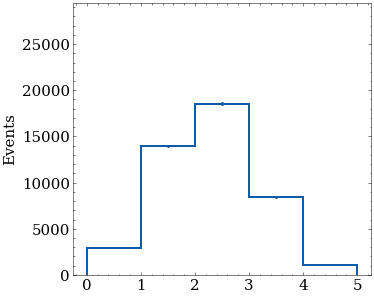

In [131]:
hist_multi([nfound_higgs])

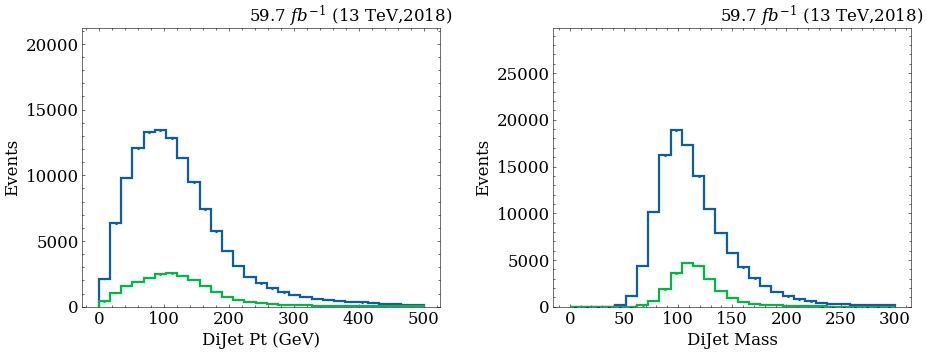

In [130]:
study.quick(
    [tree, tree],
    masks=[lambda t : t.dijet_signalId==-1, lambda t : t.dijet_signalId>-1],
    varlist=['dijet_pt','dijet_m'],
    # dim=(-1,1),
)

# GNN Model

In [24]:
bkgtrees.extend(kwargs=lambda t : dict(nfound_presel=ak.zeros_like(t.n_jet)))

[None]

# Node Level Classification

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


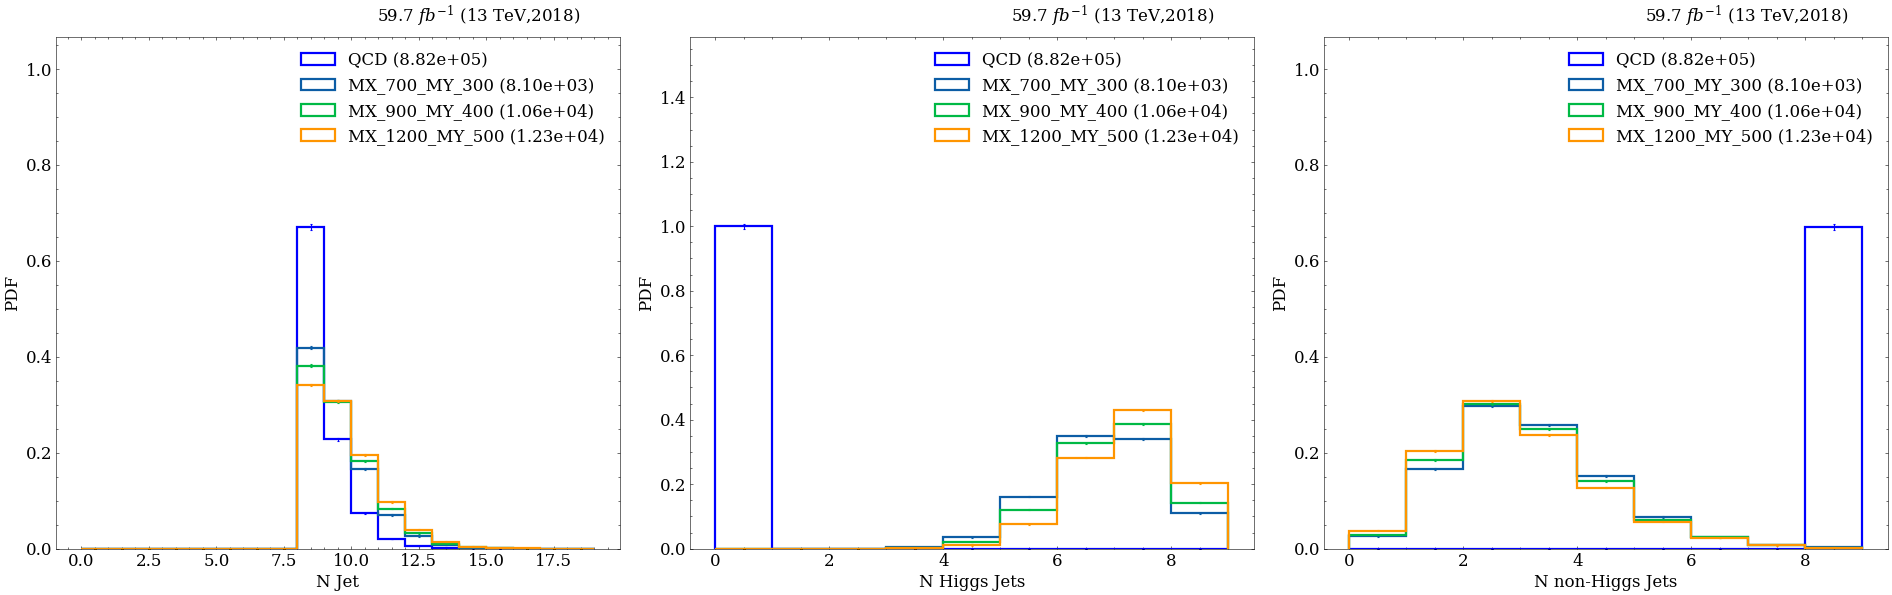

In [25]:
varinfo.clear()
study.quick(
    bkgtrees+signaltrees,
    varlist=['n_jet','nfound_presel',lambda t:t.n_jet-t.nfound_presel],
    xlabels=["N Jet","N Higgs Jets","N non-Higgs Jets"],
    binlist=[np.arange(20),np.arange(10),np.arange(10)],
    legend=True,density=True,
    dim=(-1,3),
    size=(8,8),

    # ratio=True,r_inv=True,r_ylim=(0.1,1.9)
)

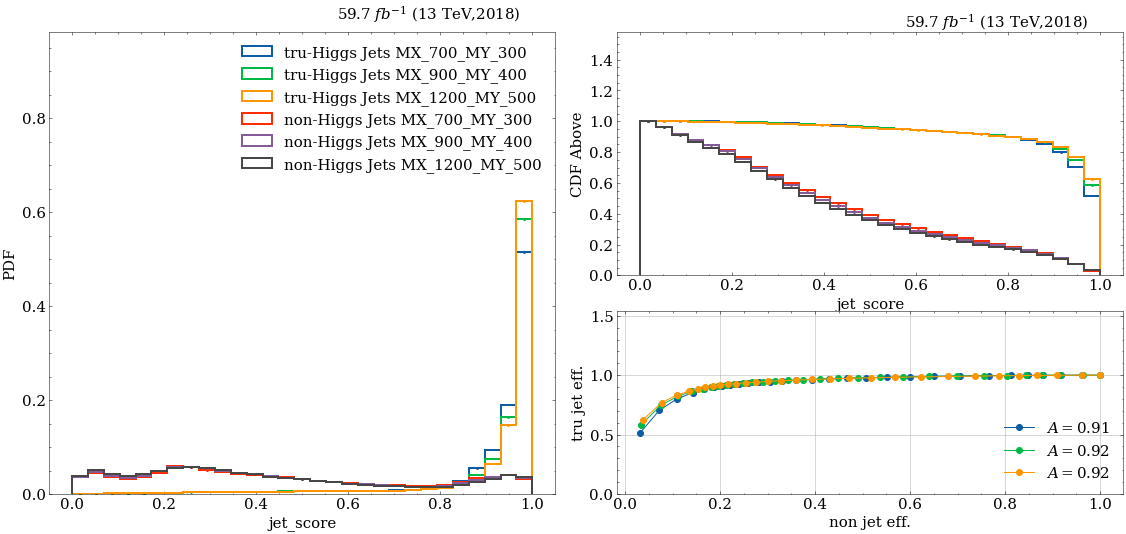

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))


masks=[lambda t : t.jet_signalId > -1]*3+[lambda t : t.jet_signalId == -1]*3
label=signaltrees.sample.apply(lambda n : f'tru-Higgs Jets {n}').list+signaltrees.sample.apply(lambda n : f'non-Higgs Jets {n}').list

study.quick(
    signaltrees+signaltrees,
    masks=masks,
    label=label,
    varlist=['jet_score'], binlist=[np.linspace(0,1,30)],
    h_label_stat=None,legend=True,
    density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    signaltrees+signaltrees,
    masks=masks,
    label=label,
    varlist=['jet_score'], binlist=[np.linspace(0,1,30)],
    # h_label_stat=None,legend=True,density=True,
    size=(10,8),
    cumulative=-1,
    correlation=True, c_group=[(3,0),(4,1),(5,2)], c_ylabel='tru jet eff.', c_xlabel='non jet eff.',

    figax=(fig,axs[1]),

)

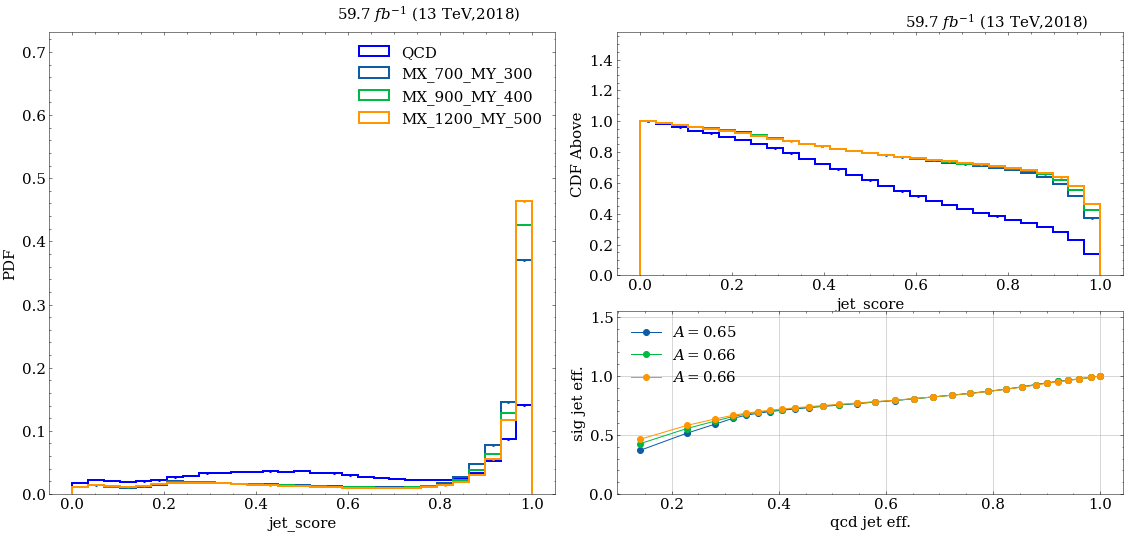

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))


study.quick(
    bkgtrees+signaltrees,
    varlist=['jet_score'], binlist=[np.linspace(0,1,30)],
    h_label_stat=None,legend=True,
    density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    bkgtrees+signaltrees,
    varlist=['jet_score'], binlist=[np.linspace(0,1,30)],
    # h_label_stat=None,legend=True,density=True,
    size=(10,8),
    cumulative=-1,
    correlation=True, c_ylabel='sig jet eff.', c_xlabel='qcd jet eff.',

    figax=(fig,axs[1]),

)

# Edge Level Classification

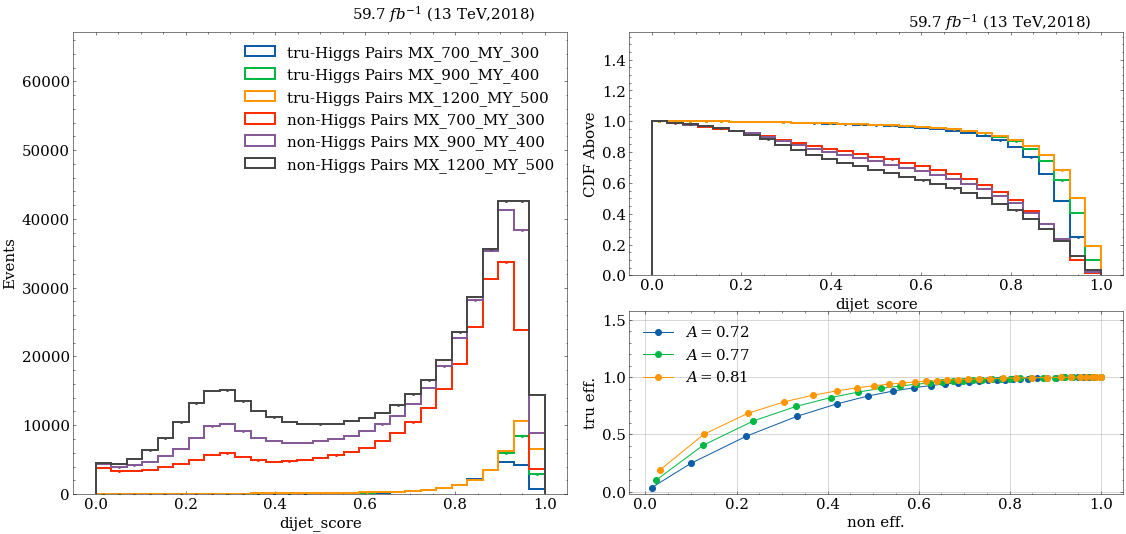

In [28]:
fig, axs = plt.subplots(ncols=2, figsize=(16,8))

study.quick(
    signaltrees+signaltrees,
    masks=[lambda t : t.dijet_signalId > -1]*3+[lambda t : t.dijet_signalId == -1]*3,
    varlist=['dijet_score'], binlist=[np.linspace(0,1,30)],
    label=signaltrees.sample.apply(lambda n : f'tru-Higgs Pairs {n}').list+signaltrees.sample.apply(lambda n : f'non-Higgs Pairs {n}').list,
    h_label_stat=None,legend=True,
    # density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    signaltrees+signaltrees,
    masks=[lambda t : t.dijet_signalId > -1]*3+[lambda t : t.dijet_signalId == -1]*3,
    varlist=['dijet_score'], binlist=[np.linspace(0,1,30)],
    label=signaltrees.sample.apply(lambda n : f'tru-Higgs Pairs {n}').list+signaltrees.sample.apply(lambda n : f'non-Higgs Pairs {n}').list,
    # h_label_stat=None,legend=True,
#     size=(10,8),
    cumulative=-1,
    correlation=True, c_group=[(3,0),(4,1),(5,2)], c_ylabel='tru eff.', c_xlabel='non eff.',

    figax=(fig,axs[1]),

)

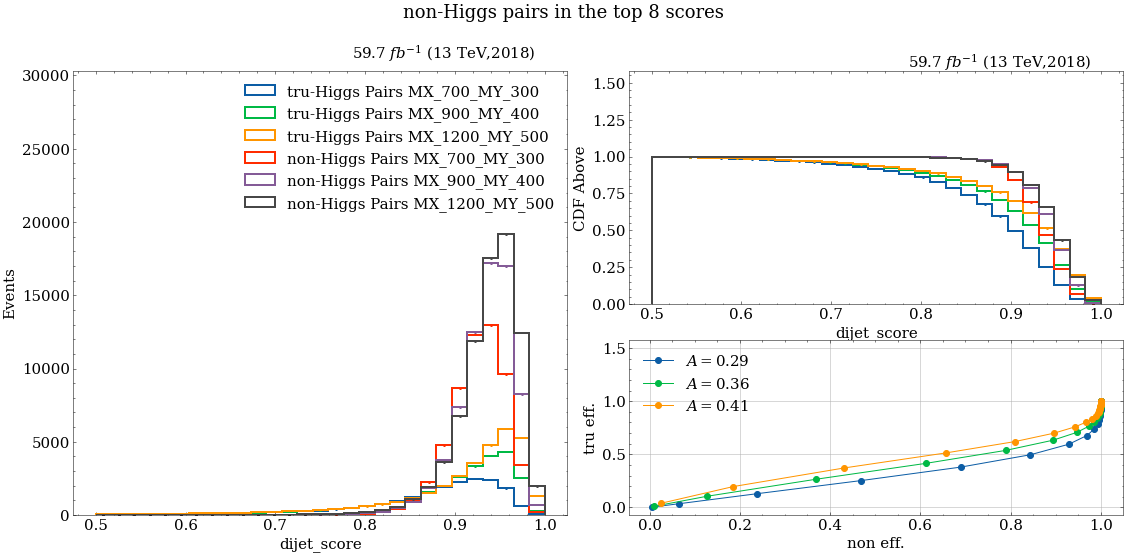

In [29]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,8))

def true_mask(tree): 
    true_pair = tree.dijet_signalId > -1
    bin_cut = tree.dijet_score > 0.5
    return true_pair & bin_cut
def fake_mask(tree):
    fake_pair = tree.dijet_signalId == -1
    true_jet = (tree.jet_signalId[tree.dijet_j1Idx] > -1) & (tree.jet_signalId[tree.dijet_j2Idx] > -1)

    score = tree.dijet_score
    top8 = ak.argsort(-score)[:,:8]
    top8_mask = get_jet_index_mask(score, top8)
    

    bin_cut = tree.dijet_score > 0.5


    return fake_pair & bin_cut & top8_mask


masks=[true_mask]*3+[fake_mask]*3
label=signaltrees.sample.apply(lambda n : f'tru-Higgs Pairs {n}').list+signaltrees.sample.apply(lambda n : f'non-Higgs Pairs {n}').list

study.quick(
    signaltrees+signaltrees,
    masks=masks,
    varlist=['dijet_score'], binlist=[np.linspace(0.5,1,30)],
    label=label,
    h_label_stat=None,legend=True,
    # density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    signaltrees+signaltrees,
    masks=masks,
    varlist=['dijet_score'], binlist=[np.linspace(0.5,1,30)],
    label=label,
    # h_label_stat=None,legend=True,
#     size=(10,8),
    cumulative=-1,
    correlation=True, c_group=[(3,0),(4,1),(5,2)], c_ylabel='tru eff.', c_xlabel='non eff.',

    figax=(fig,axs[1]),

)
fig.suptitle('non-Higgs pairs in the top 8 scores')
fig.tight_layout()

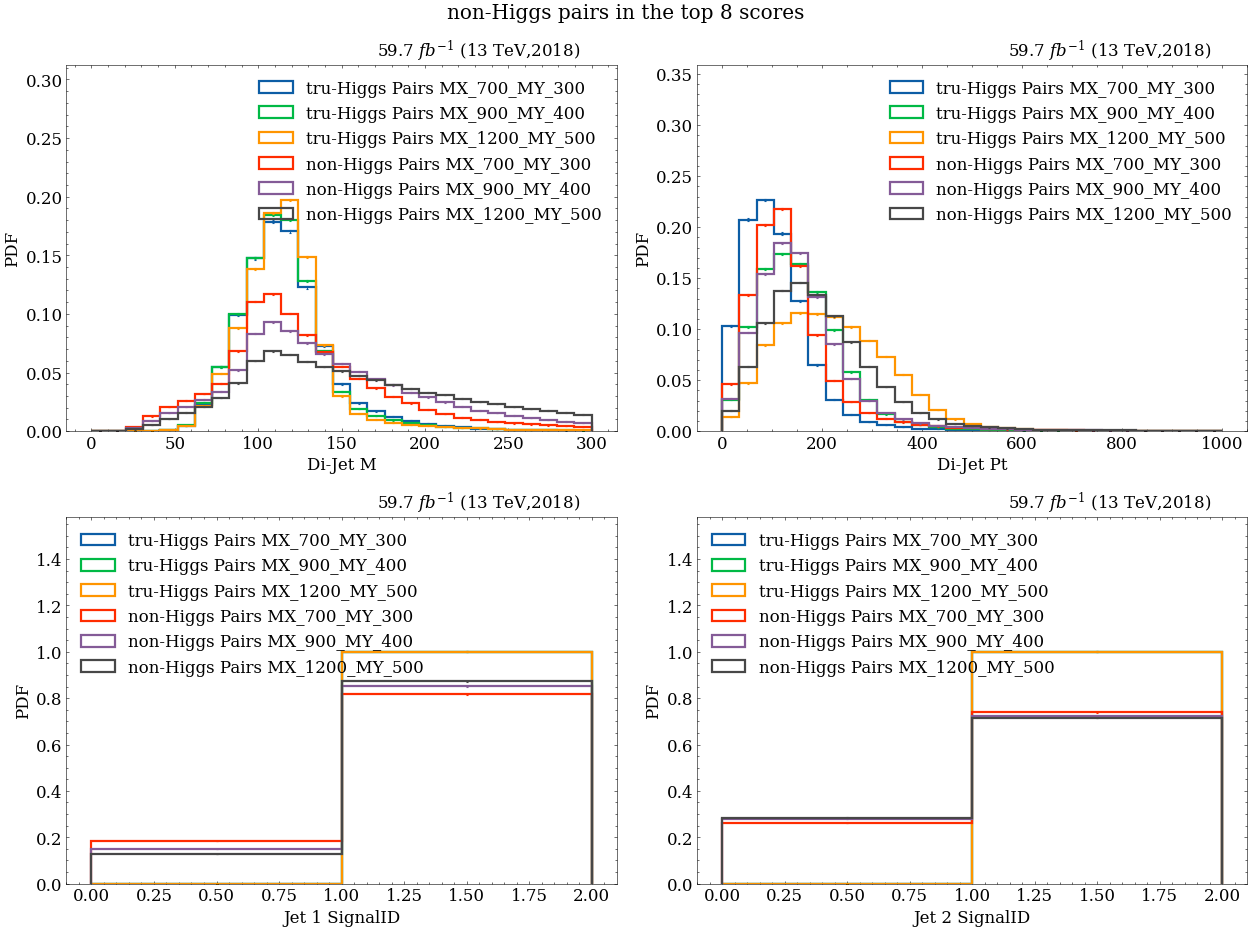

In [30]:
study.quick(
    signaltrees+signaltrees,
    masks=masks,
    varlist=['dijet_m','dijet_pt', lambda t : ak.where(t.jet_signalId[t.dijet_j1Idx]==-1,0,1), lambda t : ak.where(t.jet_signalId[t.dijet_j2Idx]==-1,0,1)], 
    binlist=[np.linspace(0,300,30), np.linspace(0,1000,30)],
    xlabels=["Di-Jet M","Di-Jet Pt","Jet 1 SignalID","Jet 2 SignalID"],
    label=label,
    h_label_stat=None,legend=True,
    density=True,
    size=(8,6),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    title='non-Higgs pairs in the top 8 scores',
)


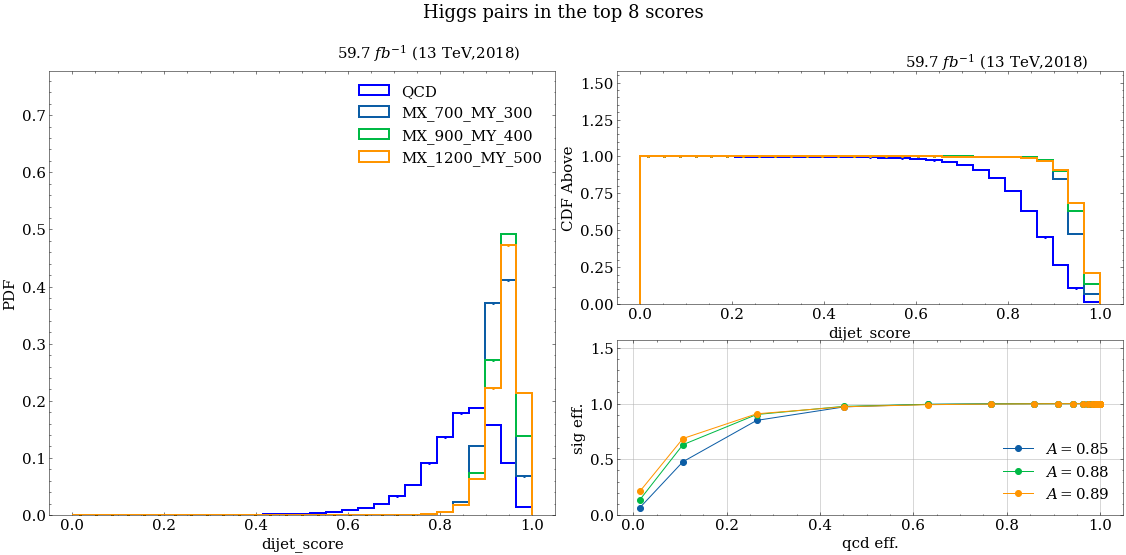

In [31]:
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(16,8))

def top8_mask(tree):
    score = tree.dijet_score
    top8 = ak.argsort(-score)[:,:8]
    top8_mask = get_jet_index_mask(score, top8)
    return top8_mask


masks=top8_mask

study.quick(
    bkgtrees+signaltrees,
    masks=masks,
    varlist=['dijet_score'], binlist=[np.linspace(0,1,30)],
    h_label_stat=None,legend=True,
    density=True,
    size=(10,8),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

    figax=(fig,axs[0]),
)

study.quick(
    bkgtrees+signaltrees,
    masks=masks,
    varlist=['dijet_score'], binlist=[np.linspace(0,1,30)],
    # h_label_stat=None,legend=True,
#     size=(10,8),
    cumulative=-1,
    correlation=True, c_ylabel='sig eff.', c_xlabel='qcd eff.',

    figax=(fig,axs[1]),

)
fig.suptitle('Higgs pairs in the top 8 scores')
fig.tight_layout()

In [33]:
(bkgtrees+signaltrees).apply(lambda t : select_higgs(t, field='score', nhiggs=4))

[None, None, None, None]

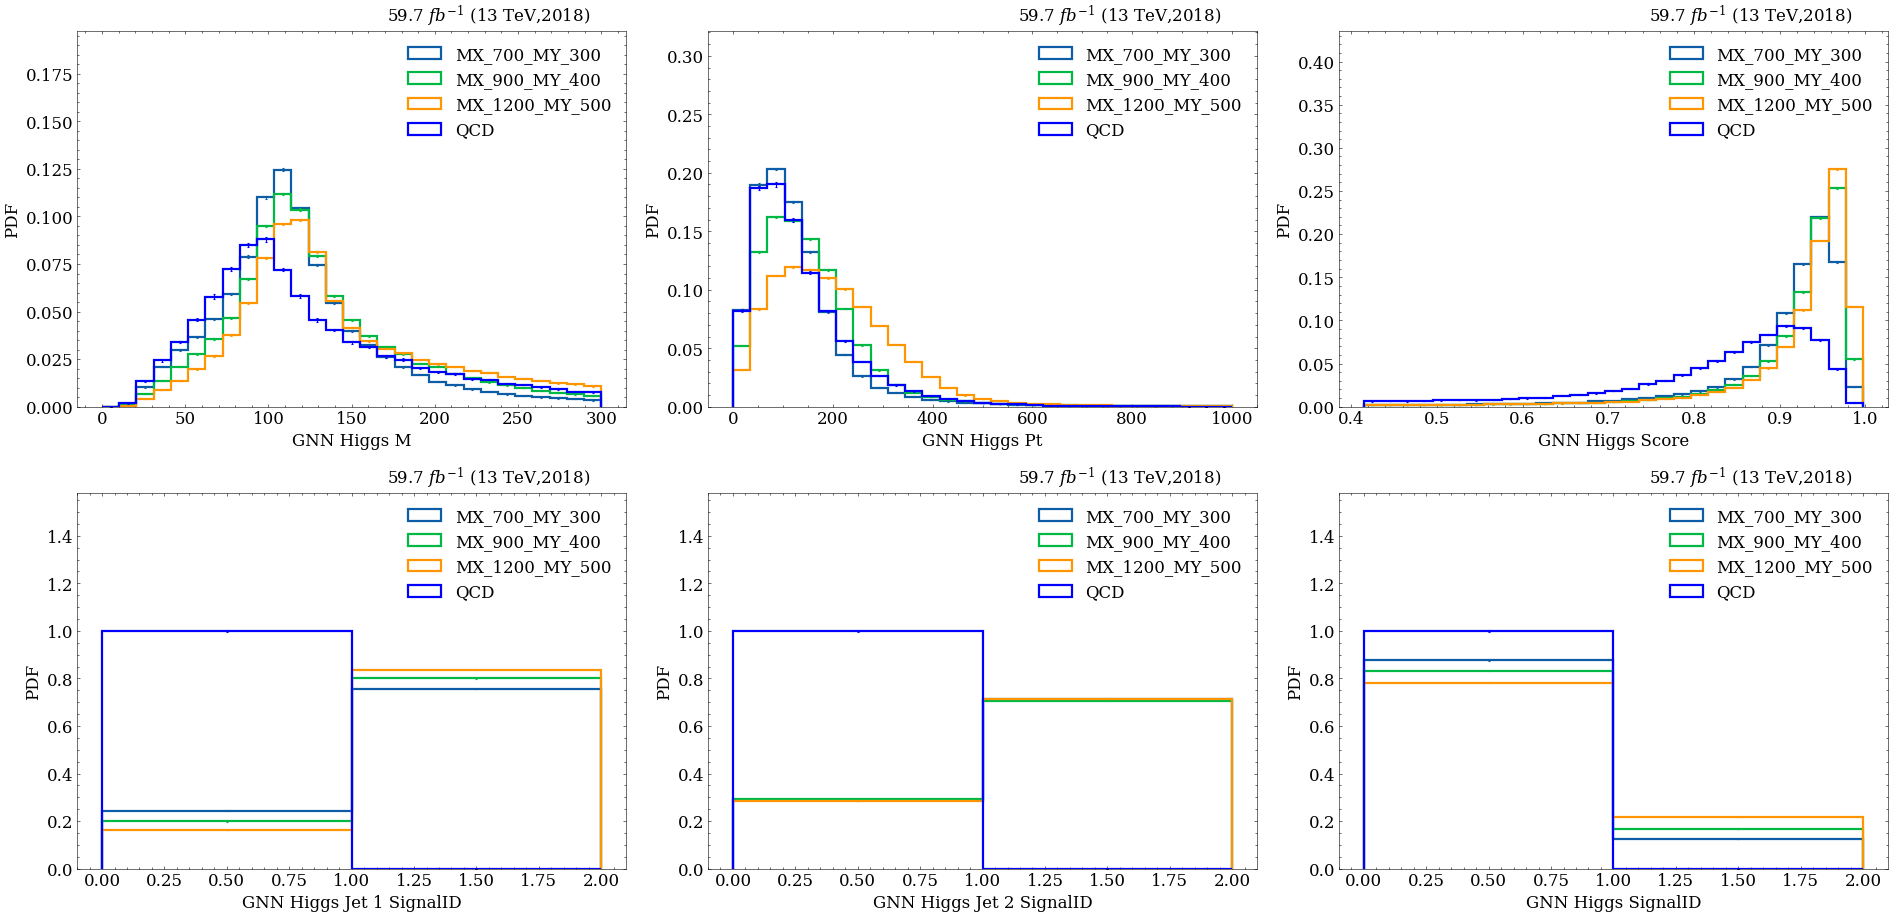

In [34]:
study.quick(
    signaltrees+bkgtrees,
    varlist=['gnn_higgs_m','gnn_higgs_pt', 'gnn_higgs_score',
    lambda t : ak.where(t.jet_signalId[t.gnn_higgs_j1Idx]==-1,0,1), lambda t : ak.where(t.jet_signalId[t.gnn_higgs_j2Idx]==-1,0,1), lambda t : ak.where(t.gnn_higgs_signalId==-1,0,1)], 
    binlist=[np.linspace(0,300,30), np.linspace(0,1000,30)],
    xlabels=["GNN Higgs M","GNN Higgs Pt","GNN Higgs Score","GNN Higgs Jet 1 SignalID","GNN Higgs Jet 2 SignalID","GNN Higgs SignalID"],
    # label=label,
    h_label_stat=None,legend=True,
    density=True,
    size=(8,6),dim=(-1,3),
    # cumulative=-1,
    # correlation=True, c_group=[(0,3),(1,4),(2,5)]

)
